In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2);library(magrittr); library(dendextend)
%R library(rwantshue)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to dendextend version 0.18.3

Type ?dendextend to access the overall documentation and
vignette('dendextend') for the package vignette.
You can execute a demo of the package via: demo(dendextend)

More information is available on the dendextend project web-site:
https://github.com/talgalili/dendextend/

Contact: <tal.galili@gmail.com>
Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues

			To suppress the this message use:
			suppressPackageStartupMessages(library(dendextend))


Attaching package: ‘dendextend’

The following object is masked from ‘package:magrittr’:

    %>%

The following object is masked from ‘package:dplyr’:

    %>%

The following object is masked from ‘package:stats’:

    cutree



<StrVector - Python:0x109cc2f38 / R:0x1070396b0>
[str, str, str, ..., str, str, str]

In [2]:
%%R 
palette(c("black", "red", "springgreen1", "violet","hotpink4","yellow3","darkorange","aquamarine4","skyblue3","red3","slateblue","darkorchid","cyan3","gray","black","brown"))

#looking into the relatedness of group members 
read_cov<-read.table("../ImportantInfo/read_coverage_patterns.txt", sep="\t", header=TRUE)
blast<-read.table("/Users/jmb/Desktop/ViralFate/phage_v_phage_blast_info.txt", sep="\t")
phage_grps<-read.table("/Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/phage_by_group.txt")
colnames(phage_grps)<-c("phage","prelim_grp")


terminase<-read.table("/Users/jmb/Desktop/ViralFate/Terminase/new_terminase_categories.txt", sep="\t", header=FALSE)

data<-blast

shared<-group_by(data, q_phage, t_phage)%>%summarise(.,sim=1-n()/(median(t_num_orfs)))
shared$sim[shared$q_phage==shared$t_phage]<-0

new_mat<-group_by(data, t_phage)%>%summarise(.)%>%.[,1]
phage<-new_mat$t_phage
    
for (member in phage){
    add<-filter(shared, q_phage==member)[c(2,3)]
    colnames(add)[2]<-member
    new_mat<-merge(new_mat, add, by="t_phage", all.x=TRUE)

}

new_mat[is.na(new_mat)]<-1
new_mat[new_mat<0]<-0
rownames(new_mat)<-new_mat$t_phage
new_mat$t_phage<-NULL

d<-new_mat %>% as.dist %>% hclust %>% as.dendrogram

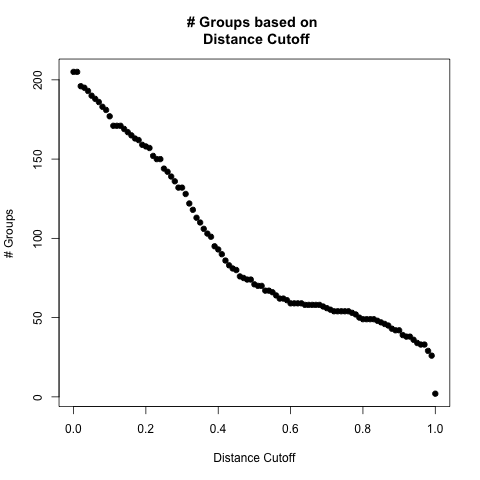

In [12]:
%%R

cut_divs<-seq(0,1,0.01)
num_groups<-vector()

for (i in cut_divs){
div<-cutree(d, k = NULL, h = i)
division<-data.frame(div)
k_val<-division$div%>%unique%>%length
num_groups<-c(num_groups, k_val)
}
plot(cut_divs, num_groups, pch=19, col="black", main="# Groups based on \n Distance Cutoff", xlab="Distance Cutoff", ylab="# Groups")

In [3]:
%%R
#div<-cutree(d, k = NULL, h = 0.7)
div<-cutree(d, k = 60)
division<-data.frame(div)
division$phage<-rownames(division)
k_val<-division$div%>%unique%>%length

division[!duplicated(division$div,fromLast=TRUE), ]->div_rep
div_rep$rep=1
division$rep<-div_rep$rep[match(division$phage, div_rep$phage)]
division[is.na(division)]<-0
head(division)
div_rep_col<-data.frame(rep_col=c("black","red"), rep=c(0,1))
division$rep_col<-div_rep_col$rep_col[match(division$rep, div_rep_col$rep)]

head(division)
print(k_val)

[1] 60


In [4]:
%%R
head(phage_grps)
together<-merge(division, phage_grps, by="phage")
together[together$rep==1,]%>%group_by(prelim_grp)%>%summarize(count=n())%>%.[order(-.$count),]

Source: local data frame [19 x 2]

   prelim_grp count
1   CNSv2.0:1    14
2   CNSv2.0:2     5
3   CNSv2.0:3     5
4   CNSv2.0:8     5
5   CNSv2.0:7     4
6   CNSv2.0:9     4
7  CNSv2.0:11     3
8  CNSv2.0:15     3
9   CNSv2.0:5     3
10 CNSv2.0:16     2
11 CNSv2.0:17     2
12  CNSv2.0:6     2
13    NoGroup     2
14 CNSv2.0:10     1
15 CNSv2.0:12     1
16 CNSv2.0:13     1
17 CNSv2.0:14     1
18 CNSv2.0:18     1
19  CNSv2.0:4     1


In [6]:
%%R

term_cats<-terminase$V3%>%unique
N<-term_cats%>%length
scheme<-iwanthue()
colors=scheme$hex(N, color_space=hcl_presets$intense)
terminase_cols<-data.frame(colors=colors, cat=term_cats)
terminase$term_col<-terminase_cols$colors[match(terminase$V3, terminase_cols$cat)]

group_cats<-phage_grps$prelim_grp%>%unique
N<-group_cats%>%length
scheme<-iwanthue()
colors=scheme$hex(N, color_space=hcl_presets$intense)
group_cols<-data.frame(colors=colors, cat=group_cats)
phage_grps$col<-group_cols$colors[match(phage_grps$prelim_grp, group_cols$cat)]

N=length(group_cats)
scheme<-iwanthue()
colors=scheme$hex(N, color_space=hcl_presets$intense)
palette(colors)

terminase_cols<-as.numeric(terminase$term_col[match(labels(d),terminase$V1)])

grp_cols<-as.numeric(phage_grps$col[match(labels(d), phage_grps$phage)])

div_rep_cols<-as.numeric(division$rep_col[match(labels(d), division$phage)])


png(filename="Representatives_10_21.png", width=4*300, height=9*300, res=300, pointsize=8)
layout(matrix(c(1,1,2,2),2,2,byrow=TRUE), heights=c(40, 10))
par(mar=c(4,4,4,4))
d %>% set("labels_colors", div_rep_cols) %>%set("leaves_pch",19)%>%set("leaves_col",grp_cols)%>%set("leaves_cex",1)%>%plot(horiz=TRUE)
#d %>%set("leaves_pch",19)%>%set("leaves_col",terminase_cols)%>%set("leaves_cex",2)%>%plot(horiz=TRUE)
#colored_bars(colors=bar_col, horiz=TRUE, dend=d)
#if(k_val>1){
 #   d %>% rect.dendrogram(k=k_val, border="gray", horiz=TRUE, lty=2, lwd=3, lower_rect=-0.15)
  #  }

  #  }
par(mar=c(0,0,0,0))
plot.new()
legend("center",legend = group_cols$cat, fill = group_cols$colors, ncol=2, title="Preliminary Phage Group")
dev.off()



quartz_off_screen 
                2 


In [7]:
!open Representatives_10_21.png -a Preview

In [8]:
%%R
division[!duplicated(division$div,fromLast=TRUE), ]%>%print

         div    phage rep rep_col
1.009.O.   5 1.009.O.   1     red
1.020.O.  10 1.020.O.   1     red
1.029.O.  14 1.029.O.   1     red
1.031.O.  15 1.031.O.   1     red
1.052.A.  19 1.052.A.   1     red
1.063.O.  20 1.063.O.   1     red
1.077.O.  22 1.077.O.   1     red
1.081.O.  24 1.081.O.   1     red
1.101.O.  25 1.101.O.   1     red
1.111.B.  27 1.111.B.   1     red
1.112.O.   9 1.112.O.   1     red
1.121.O.  30 1.121.O.   1     red
1.123.O.  31 1.123.O.   1     red
1.126.O.  32 1.126.O.   1     red
1.144.O.  35 1.144.O.   1     red
1.151.O.  36 1.151.O.   1     red
1.154.O.  37 1.154.O.   1     red
1.170.O.  42 1.170.O.   1     red
1.181.O.   2 1.181.O.   1     red
1.182.O.  45 1.182.O.   1     red
1.185.O.  11 1.185.O.   1     red
1.190.O.  40 1.190.O.   1     red
1.193.O.  39 1.193.O.   1     red
1.202.O.  47 1.202.O.   1     red
1.204.O.  48 1.204.O.   1     red
1.205.O.  49 1.205.O.   1     red
1.209.O.   8 1.209.O.   1     red
1.210.O.  23 1.210.O.   1     red
1.211.B.  46 1

In [9]:
%%R
write.table(division[,c(2,1,3)], file="division_tbl_k=60.txt", sep="\t", quote=FALSE, row.names=FALSE)

In [10]:
!open division_tbl_k=60.txt -a textedit